In [103]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from tensorflow import keras
from keras.layers import Normalization

In [106]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

Загрузка датасета

In [107]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/content/prochnost.csv")

# Display the first 3 examples.
HV_max = dataset_df['HV'].max()
D2_max = dataset_df['D2'].max()
D1_max = dataset_df['D1'].max()
MWCNT_max = dataset_df['MWCNT'].max()
P_max = dataset_df['P'].max()

#Нормализация
dataset_df['HV'] = dataset_df['HV']/HV_max
dataset_df['D2'] = dataset_df['D2']/D2_max
dataset_df['D1'] = dataset_df['D1']/D1_max
dataset_df['MWCNT'] = dataset_df['MWCNT']/MWCNT_max
dataset_df['P'] = dataset_df['P']/P_max

Функция для разделения датасета на выборку для обучения и выборку для тестирования (в соотношении 70 к 30)

In [108]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]
  
#norm = Normalization()
#norm.adapt(dataset_df) # you can use dataset.take(N) if N samples is enough for it to figure out the mean & variance.

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

31 examples in training, 20 examples for testing.


Поместить в лэйбл имя предсказываемого параметра

In [109]:

# Name of the label column.
label = "HV"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)



Обучение модели на регрессию

In [110]:
%set_cell_height 300

# Configure the model.
model_RF = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,  num_trees=100)

# Train the model.
history = model_RF.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpsc5hwzgd as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.206043. Found 31 examples.
Training model...
Model trained in 0:00:00.029802
Compiling model...
Model compiled.


Сохранение модели

In [111]:
model_RF.save("/tmp/my_saved_model")

Оценка модели по MSE, RMSE, MAE и MAPE

In [112]:
# Evaluate the model on the test dataset.
model_RF.compile(metrics=["mse", "mae", "mape"])
evaluation = model_RF.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print(f"MAE: {evaluation['mae']}")
print(f"MAPE: {evaluation['mape']}")
tfdf.model_plotter.plot_model_in_colab(model_RF, tree_idx=0, max_depth=3)

1/1 [==============================] - 0s 233ms/step - loss: 0.0000e+00 - mse: 0.0167 - mae: 0.1087 - mape: 18.0877
{'loss': 0.0, 'mse': 0.016689155250787735, 'mae': 0.10871259868144989, 'mape': 18.087711334228516}

MSE: 0.016689155250787735
RMSE: 0.12918651342453566
MAE: 0.10871259868144989
MAPE: 18.087711334228516


Вывод различной информации о модели

In [113]:
%set_cell_height 150
model_RF.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (4):
	D1
	D2
	MWCNT
	P

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  2.391500 ################
    2.   "MWCNT"  2.031167 ############
    3.       "P"  1.768500 #########
    4.      "D2"  1.289000 ####
    5.      "D1"  0.818000 

Variable Importance: NUM_AS_ROOT:
    1.    "D1" 52.000000 ################
    2.    "D2" 31.000000 ########
    3. "MWCNT" 10.000000 #
    4.     "P"  7.000000 

Variable Importance: NUM_NODES:
    1.    "D1" 154.000000 ################
    2.    "D2" 119.000000 ###########
    3.     "P" 72.000000 ####
    4. "MWCNT" 39.000000 

Variable Importance: SUM_SCORE:
    1.    "D1" 17.

In [114]:
%set_cell_height 150
model_RF.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=9, accuracy=None, loss=None, rmse=0.17378806457429274, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=30, accuracy=None, loss=None, rmse=0.1426569126988015, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=31, accuracy=None, loss=None, rmse=0.13519177805720273, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=31, accuracy=None, loss=None, rmse=0.1342476280027246, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=31, accuracy=None, loss=None, rmse=0.1324151474214893, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=31, accuracy=None, loss=None, rmse=0.1298434217928015, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=61, evaluation=Evalu

Визуализация снижения ошибки RMSE

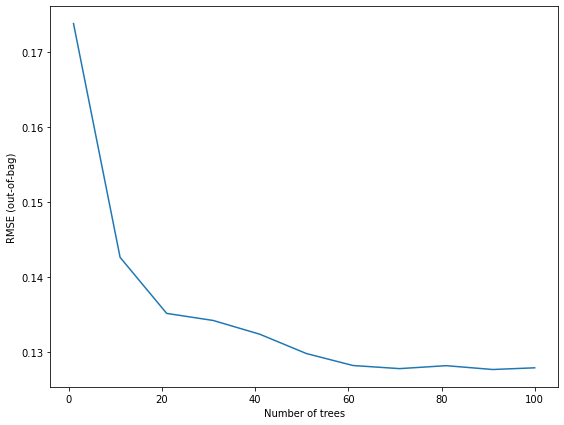

In [115]:
import matplotlib.pyplot as plt

logs = model_RF.make_inspector().training_logs()

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

Предсказание значений с помощью созданной модели

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


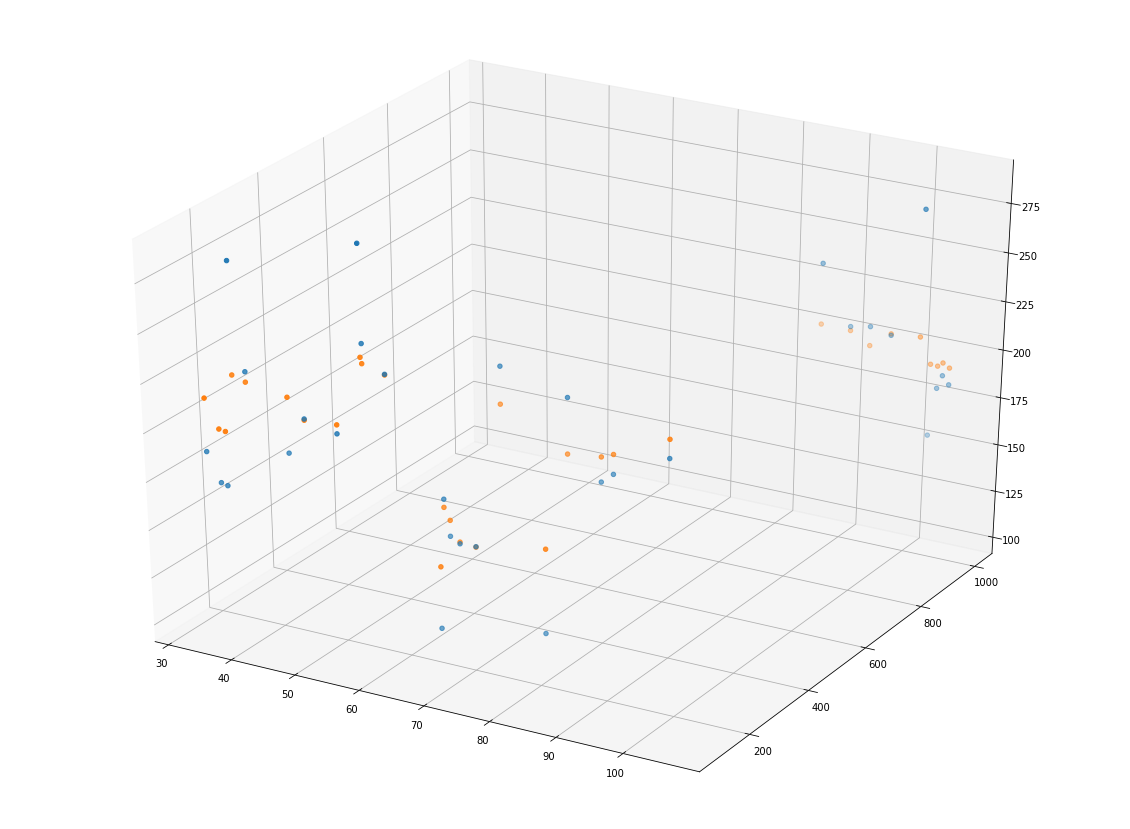

In [116]:
#Предсказанные значения для тестовой выборки
import matplotlib.pyplot as plt
predictions = model_RF.predict(train_ds, verbose=0)*HV_max
original = train_ds_pd['HV'].to_numpy()*HV_max
print(type(predictions))
print(type(original))
     
#TODO:
z1 = original
z2 = predictions
x = train_ds_pd['D1'].to_numpy()*D1_max
y = train_ds_pd['P'].to_numpy()*P_max

# plt.scatter(x,z)
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z1)
ax.scatter(x, y, z2)